<a href="https://colab.research.google.com/github/sfayhim/Projet_Safe_Driving/blob/main/Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import zipfile
import os


# Extract the ZIP file
zip_path = "/content/plaques.zip"  # Ensure this matches the uploaded file name
extract_to = "/content/plaques"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")


Files extracted to /content/plaques


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# Base directory (set after extraction)
base_dir = "/content/plaques/plaques"
folders = ["nounta", "ideria", "others"]  # Folders to augment
target_count = 155  # Target number of images per folder

# Data Augmentation Generator
datagen = ImageDataGenerator(
    rotation_range=30,       # Random rotations
    width_shift_range=0.2,   # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,         # Shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill in missing pixels
)

# Augment images in each folder
for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    images = os.listdir(folder_path)
    current_count = len(images)
    print(f"Augmenting '{folder}' with {current_count} images...")

    # Stop if the folder already has the target count
    if current_count >= target_count:
        print(f"'{folder}' already has {current_count} images.")
        continue

    # Loop to generate augmented images
    for i in range(target_count - current_count):
        # Pick a random image
        img_name = images[i % current_count]  # Loop through images cyclically
        img_path = os.path.join(folder_path, img_name)

        # Load and preprocess the image
        img = load_img(img_path)  # Load the image
        img_array = img_to_array(img)  # Convert to array
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for generator

        # Generate an augmented image
        for batch in datagen.flow(img_array, batch_size=1):
            # Save the augmented image
            new_img_name = f"aug_{i}_{img_name}"  # Unique name for the new image
            new_img_path = os.path.join(folder_path, new_img_name)
            array_to_img(batch[0]).save(new_img_path)
            break  # Generate one image per iteration

    print(f"'{folder}' now has {len(os.listdir(folder_path))} images.")

print("Data augmentation complete!")


Augmenting 'nounta' with 21 images...
'nounta' now has 155 images.
Augmenting 'ideria' with 16 images...
'ideria' now has 155 images.
Augmenting 'others' with 6 images...
'others' now has 155 images.
Data augmentation complete!


In [ ]:
!zip -r augmented_plaques.zip /content/plaques
from google.colab import files
files.download("augmented_plaques.zip")

  adding: content/plaques/ (stored 0%)
  adding: content/plaques/plaques/ (stored 0%)
  adding: content/plaques/plaques/tounsia/ (stored 0%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_74.jpg (deflated 7%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_11.jpg (deflated 3%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_140.jpg (deflated 4%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_90.jpg (deflated 4%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_40.jpg (deflated 4%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_21.jpg (deflated 5%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_154.jpg (deflated 3%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_80.jpg (deflated 5%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_44.jpg (deflated 2%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_132.jpg (deflated 4%)
  adding: content/plaques/plaques/tounsia/plaque_tounsia_54.jpg (deflated 2%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Paths
base_dir = "/content/plaques/plaques"

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values
    validation_split=0.2  # 20% for validation
)

# Training Data
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resize images
    batch_size=32,          # Number of images per batch
    class_mode='categorical',  # Multi-class classification
    subset='training'       # Use the training subset
)

# Validation Data
val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)


Found 496 images belonging to 4 classes.
Found 124 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Fully connected layers with L2 regularization
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Add Dropout to reduce overfitting

    # Output layer for classification
    Dense(4, activation='softmax')  # 4 classes: ideria, nounta, others, tounsia
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',  # Adaptive learning rate
    loss='categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)


In [ ]:
# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Number of epochs
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.8858 - loss: 0.7757 - val_accuracy: 0.8306 - val_loss: 0.9380
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8915 - loss: 0.8257 - val_accuracy: 0.7097 - val_loss: 1.2180
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8782 - loss: 0.8408 - val_accuracy: 0.7500 - val_loss: 1.1583
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9122 - loss: 0.7221 - val_accuracy: 0.8145 - val_loss: 0.9457


In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - accuracy: 0.8437 - loss: 0.9083
Validation Loss: 0.9380139708518982
Validation Accuracy: 0.8306451439857483


In [ ]:
model.save("car_plaques_cnn_model.h5")
from google.colab import files
files.download("car_plaques_cnn_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

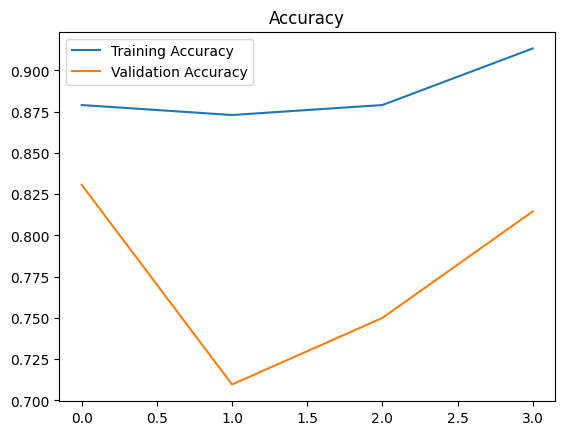

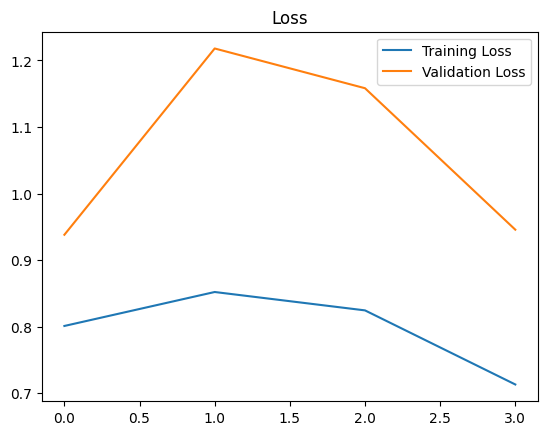

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [ ]:
# Get true labels and predicted labels
val_generator.reset()  # Reset the validation generator

# Predict the probabilities for all validation images
predictions = model.predict(val_generator)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = val_generator.classes

# Get class names
class_names = list(val_generator.class_indices.keys())


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step


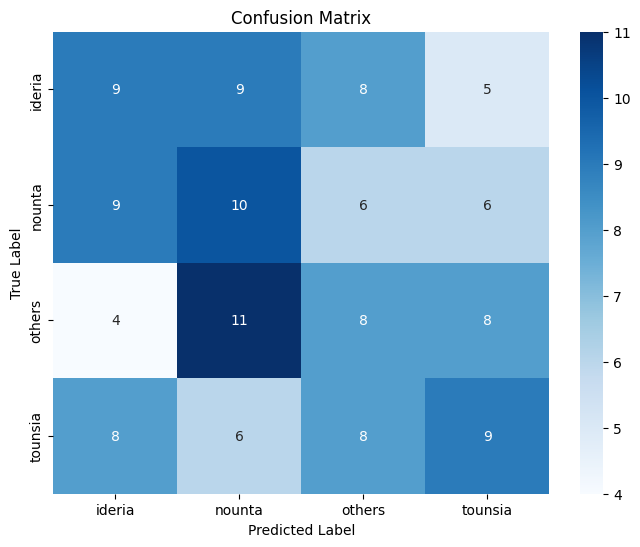

In [ ]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      ideria       0.30      0.29      0.30        31
      nounta       0.28      0.32      0.30        31
      others       0.27      0.26      0.26        31
     tounsia       0.32      0.29      0.31        31

    accuracy                           0.29       124
   macro avg       0.29      0.29      0.29       124
weighted avg       0.29      0.29      0.29       124



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load the ResNet50 base model (pretrained on ImageNet)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers (prevents changing pretrained weights)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet50
model1 = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten for better performance
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),  # Fully connected layer with L2 regularization
    Dropout(0.5),  # Dropout for regularization
    Dense(4, activation='softmax')  # Output layer: 4 classes (ideria, nounta, others, tounsia)
])

# Compile the model
model1.compile(optimizer=Adam(learning_rate=0.0001),  # Use a small learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model1.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, lr_scheduler]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 5, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.2396 - loss: 9.5295 - val_accuracy: 0.3629 - val_loss: 8.8036 - learning_rate: 1.0000e-04
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.2554 - loss: 8.7809 - val_accuracy: 0.4274 - val_loss: 8.0950 - learning_rate: 1.0000e-04
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.2710 - loss: 8.0935 - val_accuracy: 0.4758 - val_loss: 7.4538 - learning_rate: 1.0000e-04
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.3108 - loss: 7.4060 - val_accuracy: 0.4758 - val_loss: 6.8695 - learning_rate: 1.0000e-04
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.3232 - loss: 6.8187 - val_accuracy: 0.4758 - val_loss: 6.3395 - learning_rate: 1.0000e-04
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.3705 - loss: 6.2593 - val_accuracy: 0.4355 - val_loss: 5.8569 - learning_rate: 1.0000e-04
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.3607 - loss:

In [ ]:
val_loss, val_accuracy = model1.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.4946 - loss: 1.6285
Validation Loss: 1.635873556137085
Validation Accuracy: 0.4838709533214569


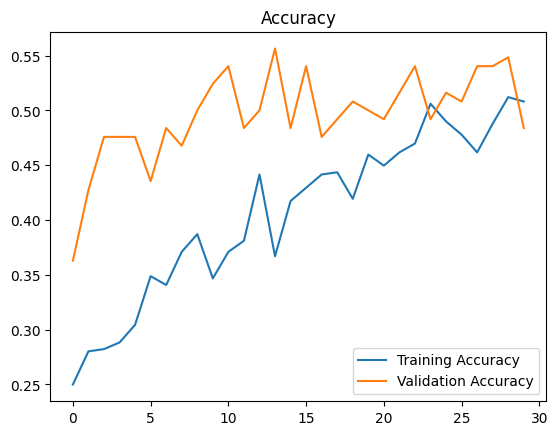

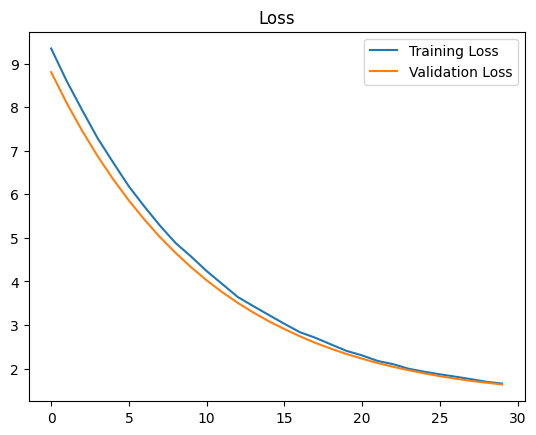

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


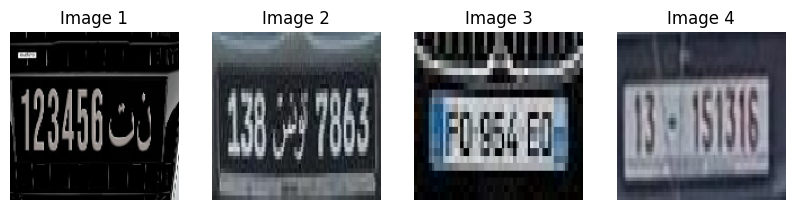

In [ ]:
# Image paths (replace with your actual file paths)
image_paths = ["/content/1.jpg","/content/2.jpeg","/content/3.jpg","/content/4.jpg"]

# Preprocessing and visualization
img_size = (150, 150)

images = []

plt.figure(figsize=(10, 5))
for i, img_path in enumerate(image_paths):
    # Load and preprocess the image
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    images.append(img_array)

    # Plot the image
    plt.subplot(1, 4, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image {i+1}")

plt.show()

# Convert to numpy array
images = np.array(images)


In [ ]:
# Predict class probabilities
predictions = model.predict(images)

# Get the class indices with the highest probabilities
predicted_classes = np.argmax(predictions, axis=1)

# Class names (update with your actual class labels)
class_names = ['ideria', 'nounta', 'others', 'tounsia']

# Print predictions
for i, pred in enumerate(predicted_classes):
    print(f"Image {i+1} is predicted as: {class_names[pred]} (Class {pred})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Image 1 is predicted as: nounta (Class 1)
Image 2 is predicted as: tounsia (Class 3)
Image 3 is predicted as: others (Class 2)
Image 4 is predicted as: ideria (Class 0)


Progress: |██████████████████████████████████████████████████| 100.0% CompleteDetected text: نت 123456 (Confidence: 0.89)


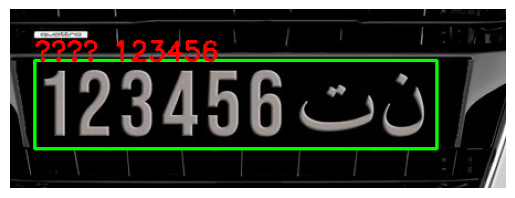

In [ ]:
!pip install easyocr

import easyocr
import cv2
import matplotlib.pyplot as plt

# Initialize the EasyOCR Reader
reader = easyocr.Reader(lang_list=['ar','en'])  # Add languages as needed

# Path to the input image
image_path = '/content/1.jpg'

# Load the image
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Detect text using EasyOCR
results = reader.readtext(image_rgb)

# Display detected text and draw bounding boxes
for (bbox, text, prob) in results:
    (top_left, top_right, bottom_right, bottom_left) = bbox
    top_left = tuple(map(int, top_left))
    bottom_right = tuple(map(int, bottom_right))

    # Draw bounding box
    cv2.rectangle(image_rgb, top_left, bottom_right, (0, 255, 0), 2)

    # Display text
    print(f"Detected text: {text} (Confidence: {prob:.2f})")
    cv2.putText(image_rgb, text, top_left, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)

# Show the image with bounding boxes
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [ ]:
!pip install arabic_reshaper
!pip install python-bidi


Detected Text: نت 123456 (Confidence: 0.89)


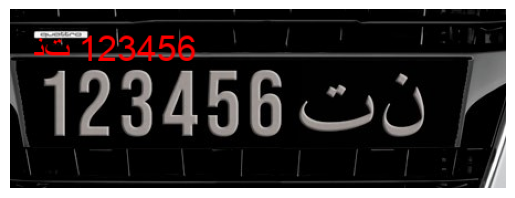

In [ ]:
import easyocr
import cv2
import numpy as np
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from PIL import ImageFont, ImageDraw, Image

# Initialize EasyOCR reader with Arabic support
reader = easyocr.Reader(['ar', 'en'])

# Function to process images and detect text using EasyOCR
def process_image(image_path, class_label):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run EasyOCR to detect text
    results = reader.readtext(image_rgb)

    # Define replacements based on class label
    replacements = {
        "nounta": "ن ت",  # For nounta class
        "tounsia": "تونس",  # For tounsia class
    }

    # Create a copy of the original image for displaying results
    image_copy = image_rgb.copy()

    # Load font for rendering Arabic text (Ensure the font supports Arabic)
    fontpath = "/content/arial.ttf"  # Replace with your actual font path
    font = ImageFont.truetype(fontpath, 32)

    # Loop over OCR results and display updated text
    for (bbox, text, prob) in results:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = tuple(map(int, top_left))
        bottom_right = tuple(map(int, bottom_right))

        # Replace '?' text manually based on the class label
        if "?" in text:
            print(f"Detected text with '?????': {text}")  # Print out detected text for debugging
            text = replacements.get(class_label, text)
            print(f"Replaced text: {text}")  # Print the replaced text for debugging

        # Reshape and bidi text for Arabic
        reshaped_text = arabic_reshaper.reshape(text)
        bidi_text = get_display(reshaped_text)

        # Create a PIL image from the OpenCV image for text rendering
        img_pil = Image.fromarray(image_copy)
        draw = ImageDraw.Draw(img_pil)

        # Draw the bounding box (on the OpenCV image, which is later converted to PIL)
        cv2.rectangle(image_copy, top_left, bottom_right, (0, 255, 0), 2)

        # Get the bounding box of the text using textbbox (instead of textsize)
        text_bbox = draw.textbbox((top_left[0], top_left[1]), bidi_text, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Adjust text position so it fits within the image and is inside the bounding box
        text_x = top_left[0]
        text_y = top_left[1] - text_height - 5  # Position the text above the box

        # Draw the corrected Arabic text on the image
        draw.text((text_x, text_y), bidi_text, font=font, fill=(255, 0, 0))  # Red text for visibility

        print(f"Detected Text: {text} (Confidence: {prob:.2f})")

    # Convert the PIL image back to OpenCV format
    img = np.array(img_pil)

    # Show the updated image with the replaced text
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Example Usage
image_path = '/content/1.jpg'  # Replace with your image path
class_label = 'nounta'  # Replace with actual class label ('nounta' or 'tounsia')

# Process the image with the given class label
process_image(image_path, class_label)
